In [1]:
import warnings
warnings.filterwarnings('ignore')

import math, time
import datetime as dt
import numpy as np
import pandas as pd
from scipy import stats, integrate
pd.set_option('precision', 4)

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

## Data Analysis

### 1. Prices-split-adjusted

In [2]:
# loading prices-split-adjusted to dataframe
prices = pd.read_csv('datasets/prices.csv', parse_dates = ['date'])
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.43,125.84,122.31,126.25,2163600.0
1,2016-01-06,WLTW,125.24,119.98,119.94,125.54,2386400.0
2,2016-01-07,WLTW,116.38,114.95,114.93,119.74,2489500.0
3,2016-01-08,WLTW,115.48,116.62,113.50,117.44,2006300.0
4,2016-01-11,WLTW,117.01,114.97,114.09,117.33,1408600.0


In [3]:
# number of missing value for each variable
prices.isnull().sum(axis=0)

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64

In [4]:
# type of variable
dtype_prices = prices.dtypes.reset_index()
dtype_prices.columns = ["VARIABLE", "DType"]
dtype_prices.groupby("DType").aggregate('count').reset_index()

,DType,VARIABLE
0,datetime64[ns],1
1,float64,5
2,object,1


In [5]:
# extract all symbols from the list
symbols = list(set(prices.symbol))
print("Number of symbols:", len(symbols))
print("Example of what is in symbols:", symbols[:10])

Number of symbols: 501
Example of what is in symbols: ['FDX', 'AMP', 'BEN', 'GOOG', 'HRB', 'XEC', 'ORCL', 'MNST', 'MO', 'L']


In [6]:
# extract a particular price for stock in symbols: use APPLE as an example
APPLE = prices[prices['symbol']=='AAPL']
APPLE.head()

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,213.43,214.01,212.38,214.50,1.2343e+08
721,2010-01-05,AAPL,214.60,214.38,213.25,215.59,1.5048e+08
1189,2010-01-06,AAPL,214.38,210.97,210.75,215.23,1.3804e+08
1657,2010-01-07,AAPL,211.75,210.58,209.05,212.00,1.1928e+08
2125,2010-01-08,AAPL,210.30,211.98,209.06,212.00,1.1190e+08


In [7]:
APPLE.describe(include = 'all')

,date,symbol,open,close,low,high,volume
count,1762,1762,1762.0000,1762.0000,1762.0000,1762.0000,1.7620e+03
unique,1762,1,NaN,NaN,NaN,NaN,NaN
top,2016-11-14 00:00:00,AAPL,NaN,NaN,NaN,NaN,NaN
freq,1,1762,NaN,NaN,NaN,NaN,NaN
first,2010-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2016-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,313.0763,312.9271,309.8282,315.9113,9.4226e+07
std,NaN,NaN,185.2995,185.1471,183.3839,186.8982,6.0205e+07
min,NaN,NaN,90.0000,90.2800,89.4700,90.7000,1.1476e+07
25%,NaN,NaN,115.2225,115.1900,114.0025,116.3625,4.9175e+07


In [8]:
APPLE = APPLE.close.values.astype('float32')
APPLE.shape

(1762,)

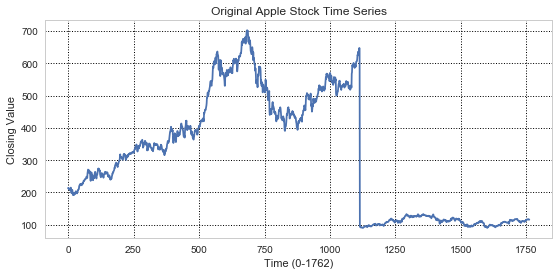

In [9]:
APPLE = APPLE.reshape(1762, 1)

plt.figure(figsize=(20, 4))
plt.subplot(121)
ax = plt.gca()
ax.plot(APPLE, color='b')
plt.xlabel('Time (0-1762)')
plt.ylabel('Closing Value')
plt.title('Original Apple Stock Time Series')
plt.axis('tight')
plt.grid(color='black', linestyle='dotted')
#plt.ylim([20,145])
plt.show()

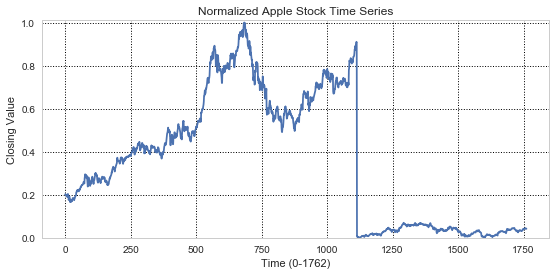

In [10]:
# normalizing the data (no log transformation and no first and second differences)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
APPLE1 = scaler.fit_transform(APPLE)

plt.figure(figsize=(20, 4))
plt.subplot(121)
ax = plt.gca()
ax.plot(APPLE1, color='b')
plt.xlabel('Time (0-1762)')
plt.ylabel('Closing Value')
plt.title('Normalized Apple Stock Time Series')
plt.axis('tight')
plt.grid(color='black', linestyle='dotted')
plt.ylim([0,1.01])
plt.show()

### 2. Fundamentals

In [11]:
# loading files to dataframe
prices = pd.read_csv('datasets/prices-split-adjusted.csv', parse_dates = ['date'])
nyse = pd.read_csv('datasets/fundamentals.csv', parse_dates = ['Period Ending'])
nyse.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.0680e+09,-2.2200e+08,-1.9610e+09,23.0,-1.8880e+09,4.6950e+09,53.0,...,7.0720e+09,9.0110e+09,-7.9870e+09,2.4891e+10,1.6904e+10,2.4855e+10,-3.6700e+08,2012.0,-5.60,3.3500e+08
1,1,AAL,2013-12-31,4.9750e+09,-9.3000e+07,-2.7230e+09,67.0,-3.1140e+09,1.0592e+10,75.0,...,1.4323e+10,1.3806e+10,-2.7310e+09,4.5009e+10,4.2278e+10,2.6743e+10,0.0000e+00,2013.0,-11.25,1.6302e+08
2,2,AAL,2014-12-31,4.6680e+09,-1.6000e+08,-1.5000e+08,143.0,-5.3110e+09,1.5135e+10,60.0,...,1.1750e+10,1.3404e+10,2.0210e+09,4.1204e+10,4.3225e+10,4.2650e+10,0.0000e+00,2014.0,4.02,7.1692e+08
3,3,AAL,2015-12-31,5.1020e+09,3.5200e+08,-7.0800e+08,135.0,-6.1510e+09,1.1591e+10,51.0,...,9.9850e+09,1.3605e+10,5.6350e+09,4.2780e+10,4.8415e+10,4.0990e+10,0.0000e+00,2015.0,11.39,6.6813e+08
4,4,AAP,2012-12-29,2.4095e+09,-8.9482e+07,6.0000e+05,32.0,-2.7118e+08,5.2022e+08,23.0,...,3.1842e+09,2.5596e+09,1.2107e+09,3.4031e+09,4.6138e+09,6.2050e+09,-2.7095e+07,2012.0,5.29,7.3284e+07


In [12]:
# find limits for fundamentals period dates, must a price for the stock a year later for prediction
max_date = prices['date'].max() - dt.timedelta(days=365)
min_date = prices['date'].min()

# imiting fundamentals data to those dates
nyse = nyse[(nyse['Period Ending'] <= max_date)&(nyse['Period Ending'] >= min_date)]

nyse.reset_index(drop=True, inplace=True)

print("No. of samples:", nyse.shape[0])
print("No. of features:", nyse.shape[1])
print('----------------')
print(nyse.columns.values)

No. of samples: 1556
No. of features: 79
----------------
['Unnamed: 0' 'Ticker Symbol' 'Period Ending' 'Accounts Payable'
 'Accounts Receivable' "Add'l income/expense items" 'After Tax ROE'
 'Capital Expenditures' 'Capital Surplus' 'Cash Ratio'
 'Cash and Cash Equivalents' 'Changes in Inventories' 'Common Stocks'
 'Cost of Revenue' 'Current Ratio' 'Deferred Asset Charges'
 'Deferred Liability Charges' 'Depreciation'
 'Earnings Before Interest and Tax' 'Earnings Before Tax'
 'Effect of Exchange Rate' 'Equity Earnings/Loss Unconsolidated Subsidiary'
 'Fixed Assets' 'Goodwill' 'Gross Margin' 'Gross Profit' 'Income Tax'
 'Intangible Assets' 'Interest Expense' 'Inventory' 'Investments'
 'Liabilities' 'Long-Term Debt' 'Long-Term Investments' 'Minority Interest'
 'Misc. Stocks' 'Net Borrowings' 'Net Cash Flow' 'Net Cash Flow-Operating'
 'Net Cash Flows-Financing' 'Net Cash Flows-Investing' 'Net Income'
 'Net Income Adjustments' 'Net Income Applicable to Common Shareholders'
 'Net Income-Cont

We want to  find the earliest business date after the 'Period Ending' date for which we have a price for each stock and earliest date for a price one year later.

In [13]:
nsamples = len(nyse.index.values)

period_start = np.empty(nsamples,dtype=(str,10))
period_end = np.empty(nsamples,dtype=(str,10))

for i in nyse.index.values:

    ticker = nyse.loc[i]['Ticker Symbol']
    start = nyse.loc[i]['Period Ending']
    end = start + dt.timedelta(days=365)
        
    if i % 500==0: 
        
        print(i, 'rows processed')
    
    if prices[(prices['symbol']==ticker) & (prices['date']<=start + dt.timedelta(days=7))].shape[0]!=0 \
    and prices[(prices['symbol']==ticker) & (prices['date']<=end + dt.timedelta(days=7))].shape[0]!=0:
    
        #finding first date after 'Period Ending' date
        while prices[(prices['symbol']==ticker) & (prices['date']==start)].shape[0]==0:

            start += dt.timedelta(days=1)
        
        #finding first date one year later
        while prices[(prices['symbol']==ticker) & (prices['date']==end)].shape[0]==0:
            
            end += dt.timedelta(days=1)
            
        period_start[i] = start
        period_end[i] = end

print('----------------')
print(period_end.shape[0], 'end dates')
print(period_start.shape[0], 'start dates')

0 rows processed
500 rows processed
1000 rows processed
1500 rows processed
----------------
1556 end dates
1556 start dates


In [14]:
# adding start and end date to the dataframe
nyse['Start Date'] = pd.to_datetime(period_start)
nyse['End Date'] = pd.to_datetime(period_end)

In [15]:
# joining fundamental dataframe and equity price dataframe on start and end dates to get prices
nyse = pd.merge(nyse,prices,left_on=['Ticker Symbol','Start Date'],right_on=['symbol','date'],how='inner')
nyse = pd.merge(nyse,prices,left_on=['Ticker Symbol','End Date'],right_on=['symbol','date'],how='inner',
                suffixes=('_t0', '_t1'))

In [16]:
# checking for null values

print('before')
print('----------------')

null_list = []
for column in list(nyse.columns):
    num_nulls = nyse[column].isnull().sum()
    if num_nulls != 0:
        print(column, ':', num_nulls, 'Nulls')
        null_list.append(column)

exception_list = ['For Year']
for column in list(nyse.columns):
    if not column in exception_list:
        num_nulls = nyse[column].isnull().sum()
        if num_nulls != 0:
            nyse = nyse.loc[nyse[column].notnull()]

print('\n')            
print('after')
print('----------------')

for column in null_list:
    num_nulls = nyse[column].isnull().sum()
    print(column, ':', num_nulls, 'Nulls')

before
----------------
Cash Ratio : 275 Nulls
Current Ratio : 275 Nulls
Quick Ratio : 275 Nulls
For Year : 51 Nulls
Earnings Per Share : 90 Nulls
Estimated Shares Outstanding : 90 Nulls


after
----------------
Cash Ratio : 0 Nulls
Current Ratio : 0 Nulls
Quick Ratio : 0 Nulls
For Year : 0 Nulls
Earnings Per Share : 0 Nulls
Estimated Shares Outstanding : 0 Nulls


In [17]:
# Book Value
nyse['Book Value'] = nyse['Total Assets'] - nyse['Intangible Assets'] - nyse['Total Liabilities']

# Asset Turnover
nyse['Asset Turnover'] = nyse['Total Revenue'] / nyse['Total Assets'] 

# Equity Turnover
nyse['Equity Turnover'] = nyse['Total Revenue'] / nyse['Total Equity'] 

# Financial Leverage
nyse['Financial Leverage'] = nyse['Operating Income'] / nyse['Net Income']

# P/E Ratio
nyse['P/E Ratio'] = nyse['close_t0'] / nyse['Earnings Per Share']

# P/B Ratio
nyse['P/B Ratio'] = nyse['Book Value']

# P/CF Ratio
nyse['P/CF Ratio'] = (nyse['close_t0'] * nyse['Estimated Shares Outstanding']) / nyse['Net Cash Flow']

# Calculating Percentage Equity Price Change over Period
nyse['Percentage Change'] = (nyse['close_t1'] / nyse['close_t0']) - 1 

# Creating Target Feature, identifying those equities with at least a 10% increase in price
nyse['Target']= nyse['Percentage Change'].apply(lambda x: 1 if x >= 0.10 else 0)

In [18]:
# removing infinite values

print ('before:')
print('----------------')

for column in list(nyse.columns[-9:]):
    num_infs = nyse[nyse[column] == np.inf].shape[0]
    print(column, ':', num_infs, 'Infs') 
    
for column in list(nyse.columns[-9:]):
    num_infs = nyse[nyse[column] == np.inf].shape[0]
    nyse = nyse[nyse[column] != np.inf]

print('\n')  
print ('after:')
print('----------------')

for column in list(nyse.columns[-9:]):
    num_infs = nyse[nyse[column] == np.inf].shape[0]
    print(column, ':', num_infs, 'Infs') 

before:
----------------
Book Value : 0 Infs
Asset Turnover : 0 Infs
Equity Turnover : 0 Infs
Financial Leverage : 0 Infs
P/E Ratio : 0 Infs
P/B Ratio : 0 Infs
P/CF Ratio : 2 Infs
Percentage Change : 0 Infs
Target : 0 Infs


after:
----------------
Book Value : 0 Infs
Asset Turnover : 0 Infs
Equity Turnover : 0 Infs
Financial Leverage : 0 Infs
P/E Ratio : 0 Infs
P/B Ratio : 0 Infs
P/CF Ratio : 0 Infs
Percentage Change : 0 Infs
Target : 0 Infs


## Model Building

### 1. Logistic Regression, SVM, Naive Bayes

In [19]:
from sklearn import preprocessing as pp
from sklearn import linear_model as lm
from sklearn import feature_selection as fs
from sklearn import model_selection as ms
from sklearn import svm
from sklearn import metrics
from sklearn import naive_bayes as nb
from sklearn import neighbors as ne

In [20]:
nyse_feature_name = [
'Cash Ratio'
,'Cash and Cash Equivalents'
,'Current Ratio'
,'Fixed Assets'
,'Gross Profit'
,'Intangible Assets'
,'Long-Term Debt'
,'Long-Term Investments'
,'Net Cash Flow'
,'Net Cash Flow-Operating'
,'Net Cash Flows-Financing'
,'Net Cash Flows-Investing'
,'Net Income'
,'Profit Margin'
,'Quick Ratio'
,'Total Assets'
,'Total Equity'
,'Total Liabilities'
,'Total Revenue'
,'Earnings Per Share'
,'Depreciation'
,'Inventory'
,'Investments'
,'Operating Margin'
,'Research and Development'
,'Retained Earnings'
,'Book Value'
,'Asset Turnover'
,'Equity Turnover'
,'Financial Leverage'
,'P/E Ratio'
,'P/B Ratio'
,'P/CF Ratio']

In [21]:
nyse_feature = nyse[nyse_feature_name].as_matrix()
nyse_target = nyse['Target'].as_matrix()

nyse[nyse_feature_name].to_csv('datasets/nyse_feature.csv')
nyse['Target'].to_csv('datasets/nyse_target.csv')

print('No. of Samples:', nyse_feature.shape[0])
print('No. of Features:', nyse_feature.shape[1])

No. of Samples: 1185
No. of Features: 33


#### $\star$ Experiment 1

In [22]:
# scaling feature values between 0 and 1 
scaler = pp.MinMaxScaler(feature_range=(0, 1))
nyse_feature_standard = scaler.fit_transform(nyse_feature)

# train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_standard, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = svm.SVC(probability=True, kernel='linear')
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.45      0.18      0.25        51
          1       0.58      0.84      0.68        68

avg / total       0.52      0.55      0.50       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.33      0.04      0.07        51
          1       0.57      0.94      0.71        68

avg / total       0.47      0.55      0.43       119

Naive Bayes
-------------------
             precision    recall  f1-score   support

          0       0.50      0.16      0.24        51
          1       0.58      0.88      0.70        68

avg / total       0.55      0.57      0.50       119

K Nearest Neighbour
-------------------
             precision    recall  f1-score   support

          0       0.38      0.35      0.37        51
          1       0.54      0.57      0.56        68

avg / total       0.47      0.48      0.48       119



#### $\star$ Experiment 2

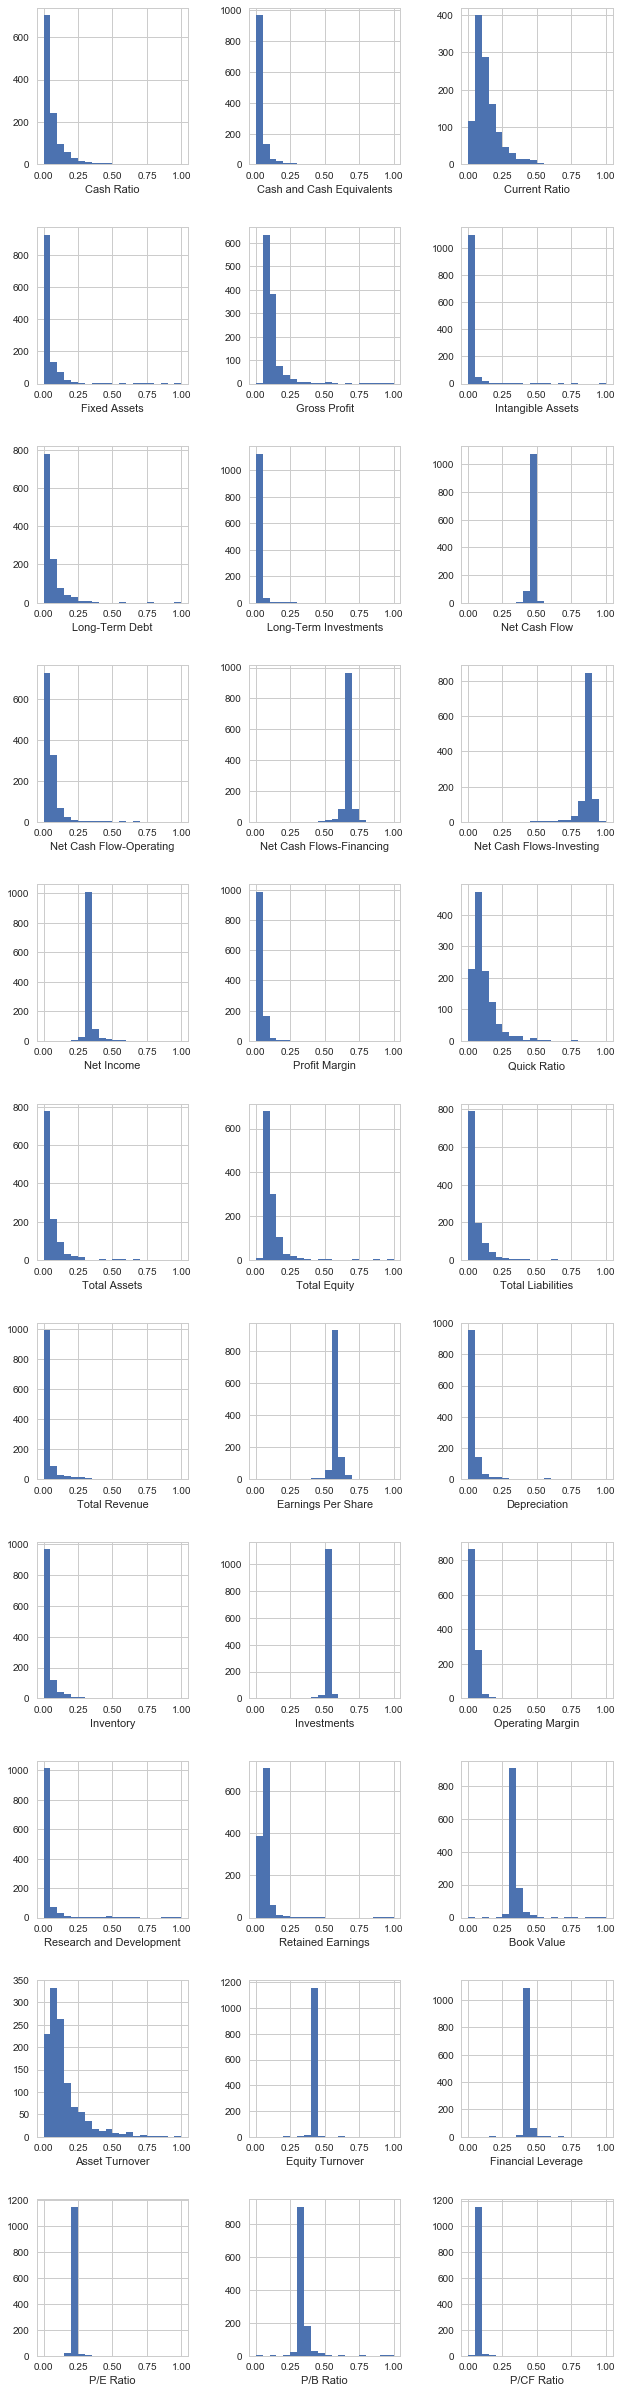

In [23]:
fig = plt.figure(figsize=(8,60))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.4)
for i in range(len(nyse_feature_name)):
    ax = fig.add_subplot(20, 3, i+1,xlabel=nyse_feature_name[i])
    ax.hist(nyse_feature_standard[:, i], bins=20)
plt.show()

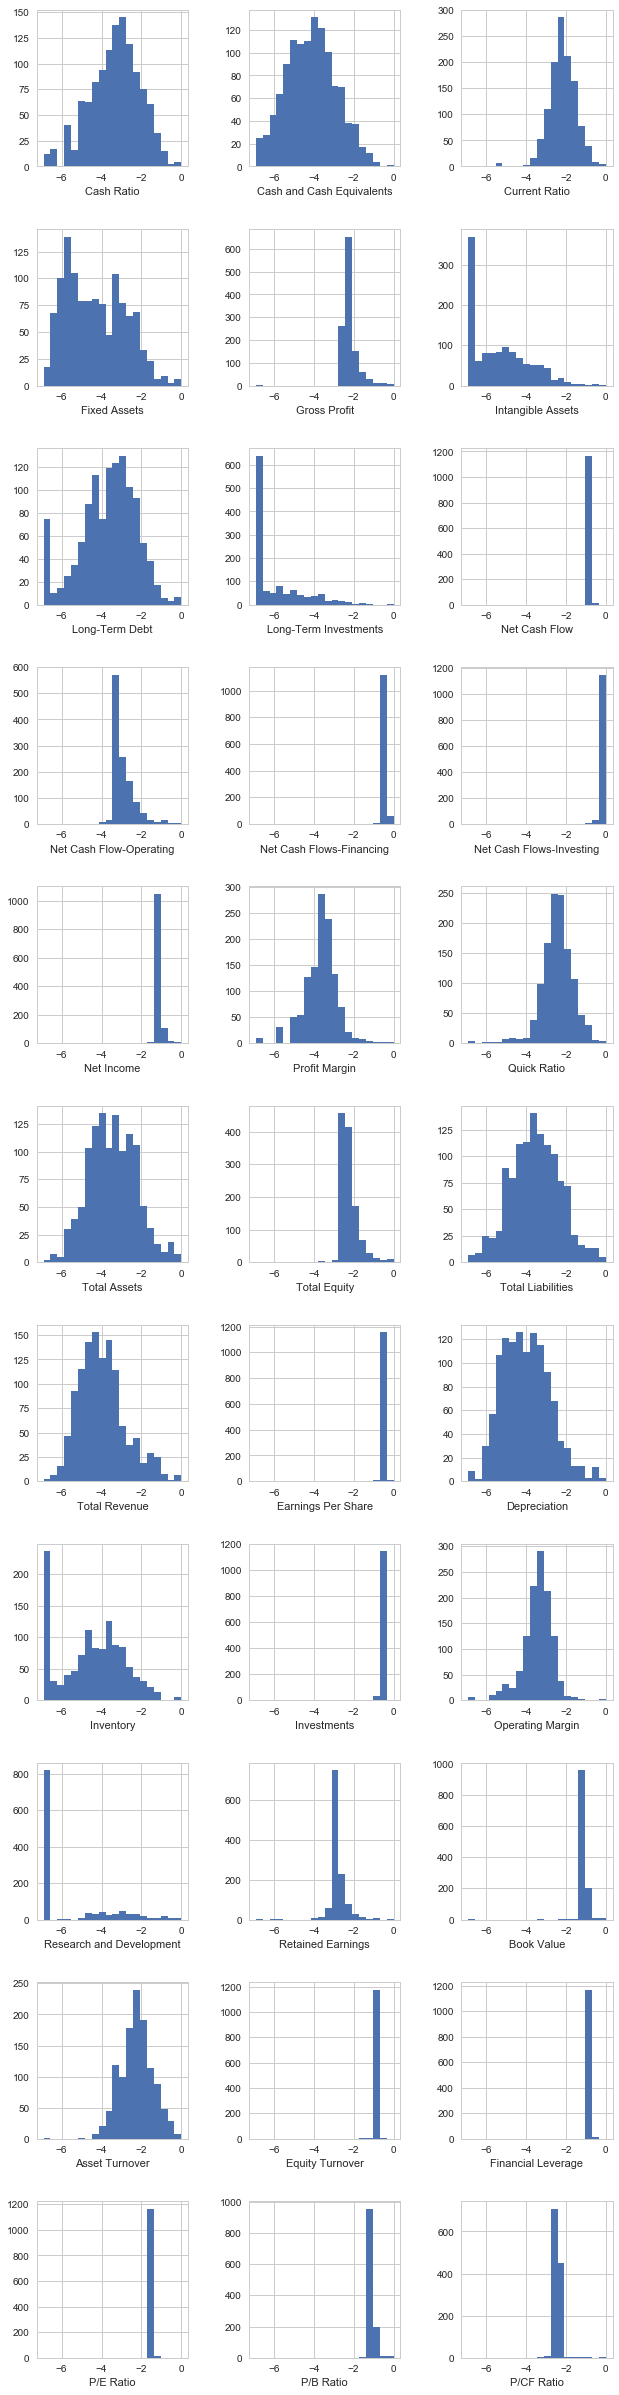

In [24]:
nyse_feature_standard_log = np.log(nyse_feature_standard + 0.001)

fig = plt.figure(figsize=(8,60))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.4)
for i in range(len(nyse_feature_name)):
    ax = fig.add_subplot(20, 3, i+1,xlabel=nyse_feature_name[i])
    ax.hist(nyse_feature_standard_log[:, i], bins=20)
plt.show()

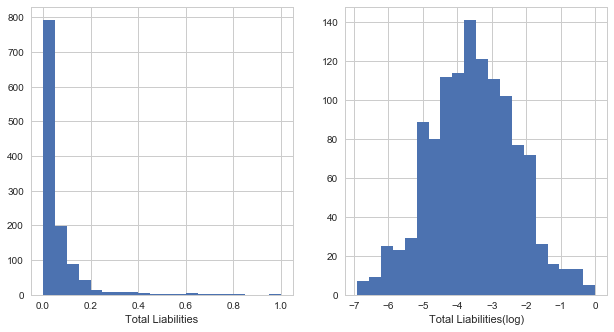

In [25]:
index = nyse_feature_name.index('Total Liabilities')

fig = plt.figure(figsize=(8,4))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.2)

ax1 = fig.add_subplot(1, 2, 1,xlabel=nyse_feature_name[index])
ax1.hist(nyse_feature_standard[:, index], bins=20)

ax2 = fig.add_subplot(1, 2, 2,xlabel=nyse_feature_name[index] + '(log)')
ax2.hist(nyse_feature_standard_log[:, index], bins=20)

plt.show()

In [26]:
# scaling Feature values between 0 and 1 
scaler = pp.MinMaxScaler(feature_range=(0, 1))
nyse_feature_standard_log = scaler.fit_transform(nyse_feature_standard_log)

# train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_standard_log, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = svm.SVC(probability=True, kernel='linear')
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.50      0.39      0.44        51
          1       0.61      0.71      0.65        68

avg / total       0.56      0.57      0.56       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.52      0.24      0.32        51
          1       0.59      0.84      0.70        68

avg / total       0.56      0.58      0.54       119

Naive Bayes
-------------------
             precision    recall  f1-score   support

          0       0.45      0.10      0.16        51
          1       0.57      0.91      0.70        68

avg / total       0.52      0.56      0.47       119

K Nearest Neighbour
-------------------
             precision    recall  f1-score   support

          0       0.47      0.43      0.45        51
          1       0.60      0.63      0.61        68

avg / total       0.54      0.55      0.54       119



#### $\star$ Experiment 3

In [27]:
# testing the standard features again the log features to see which is the more likel;y to be normally distributed
for i in range(len(nyse_feature_name)):
    arr = nyse_feature_standard[:,i]
    arr_log = nyse_feature_standard_log[:,i]
    print(nyse_feature_name[i], stats.normaltest(arr)[1] >= stats.normaltest(arr_log)[1])

Cash Ratio False
Cash and Cash Equivalents False
Current Ratio False
Fixed Assets False
Gross Profit False
Intangible Assets False
Long-Term Debt False
Long-Term Investments False
Net Cash Flow True
Net Cash Flow-Operating False
Net Cash Flows-Financing True
Net Cash Flows-Investing True
Net Income True
Profit Margin False
Quick Ratio False
Total Assets False
Total Equity False
Total Liabilities False
Total Revenue False
Earnings Per Share True
Depreciation False
Inventory False
Investments True
Operating Margin False
Research and Development False
Retained Earnings False
Book Value True
Asset Turnover False
Equity Turnover True
Financial Leverage True
P/E Ratio True
P/B Ratio True
P/CF Ratio False


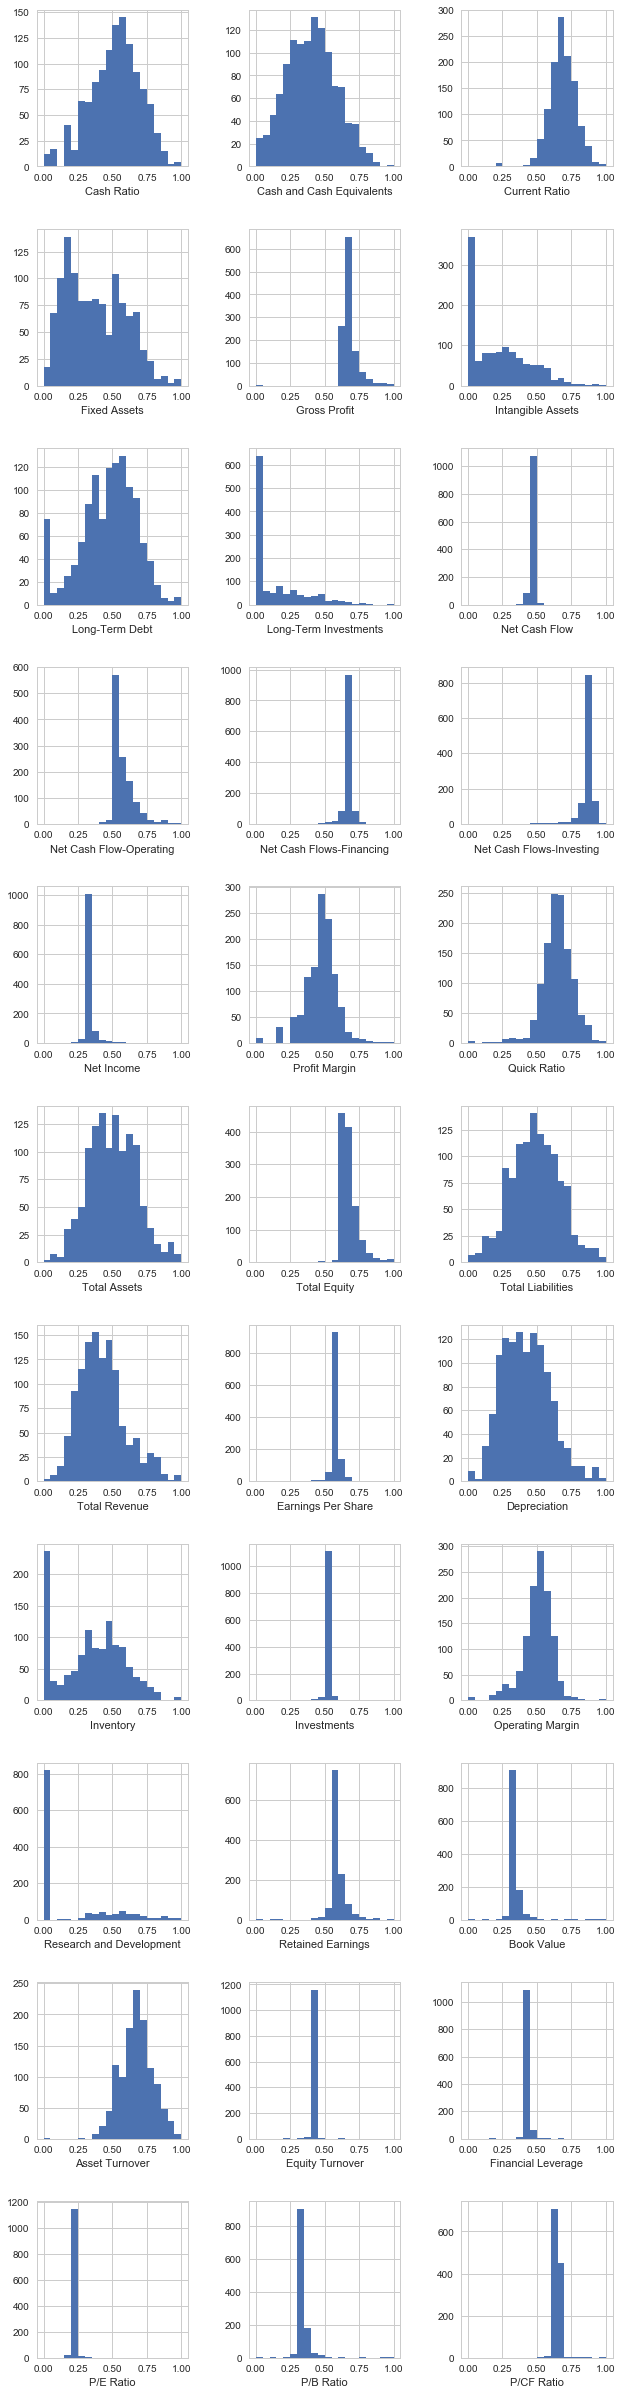

In [28]:
# creating a hybrid matrix of features where the 'more normally distributed' between standard and log is selected

normal = []
for i in range(len(nyse_feature_name)):
    arr = nyse_feature_standard[:,i]
    arr_log = nyse_feature_standard_log[:,i]
    if stats.normaltest(arr)[1] >= stats.normaltest(arr_log)[1]:
        normal.append(arr)
    else:
        normal.append(arr_log)
        
nyse_feature_hybrid = np.column_stack(normal)

fig = plt.figure(figsize=(8,60))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.4, wspace=0.4)
for i in range(len(nyse_feature_name)):
    x = nyse_feature[:, i]
    ax = fig.add_subplot(20, 3, i+1,xlabel=nyse_feature_name[i])
    ax.hist(nyse_feature_hybrid[:, i], bins=20)
plt.show()

In [29]:
# train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = svm.SVC(probability=True, kernel='linear')
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.49      0.37      0.42        51
          1       0.60      0.71      0.65        68

avg / total       0.55      0.56      0.55       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.46      0.22      0.29        51
          1       0.58      0.81      0.67        68

avg / total       0.53      0.55      0.51       119

Naive Bayes
-------------------
             precision    recall  f1-score   support

          0       0.53      0.20      0.29        51
          1       0.59      0.87      0.70        68

avg / total       0.56      0.58      0.52       119

K Nearest Neighbour
-------------------
             precision    recall  f1-score   support

          0       0.44      0.43      0.44        51
          1       0.58      0.59      0.58        68

avg / total       0.52      0.52      0.52       119



#### $\star$ Experiment 4

In [30]:
# scaling Feature values between 0 and 1 
scaler = pp.RobustScaler()
nyse_feature_hybrid_standard = scaler.fit_transform(nyse_feature_hybrid)

# train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid_standard, nyse_target, test_size=0.1, random_state=0)

model = lm.LogisticRegression()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Logistic Regression')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = svm.SVC(probability=True, kernel='linear', cache_size = 1000) #linear‘poly‘rbf‘sigmoid’
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

print('Coefficients')
print('-------------------')
for i in range(len(nyse_feature_name)):
    print(nyse_feature_name[i],':',model.coef_[:,i])

model = nb.GaussianNB()
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('Naive Bayes')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

model = ne.KNeighborsClassifier(n_neighbors=30)
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('K Nearest Neighbour')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

Logistic Regression
-------------------
             precision    recall  f1-score   support

          0       0.44      0.45      0.45        51
          1       0.58      0.57      0.58        68

avg / total       0.52      0.52      0.52       119

SVM
-------------------
             precision    recall  f1-score   support

          0       0.62      0.39      0.48        51
          1       0.64      0.82      0.72        68

avg / total       0.64      0.64      0.62       119

Coefficients
-------------------
Cash Ratio : [ 0.55645818]
Cash and Cash Equivalents : [-0.45622656]
Current Ratio : [-0.38299485]
Fixed Assets : [ 0.2687416]
Gross Profit : [ 0.01399339]
Intangible Assets : [ 0.01640458]
Long-Term Debt : [ 0.2472834]
Long-Term Investments : [ 0.13308045]
Net Cash Flow : [ 0.04467729]
Net Cash Flow-Operating : [-0.79191085]
Net Cash Flows-Financing : [-0.12740273]
Net Cash Flows-Investing : [-0.20872689]
Net Income : [-0.12628924]
Profit Margin : [-0.08940737]
Quick 

#### $\star$ Experiment 5

In [31]:
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid_standard, nyse_target, test_size=0.1, random_state=0)

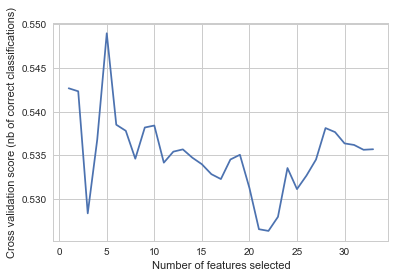

Logistic Regression
No. included features: 5
No. excluded features: 28
-------------------
             precision    recall  f1-score   support

          0       0.52      0.45      0.48        51
          1       0.63      0.69      0.66        68

avg / total       0.58      0.59      0.58       119



In [32]:
model = lm.LogisticRegression()
rfecv = fs.RFECV(estimator=model, cv=10, scoring='roc_auc')

nyse_feature_train_rfe = rfecv.fit_transform(nyse_feature_train,nyse_target_train)

nyse_feature_name_new = [nyse_feature_name[i] for i in rfecv.get_support(indices=True)]
nyse_feature_name_excluded = list(set(nyse_feature_name) - set(nyse_feature_name_new))

model.fit(nyse_feature_train_rfe, nyse_target_train)
nyse_feature_test_rfe = rfecv.transform(nyse_feature_test)

predicted = model.predict(nyse_feature_test_rfe)
probs = model.predict_proba(nyse_feature_test_rfe)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# generate evaluation metrics
print('Logistic Regression')
print('No. included features:', len(nyse_feature_name_new))
print('No. excluded features:', len(nyse_feature_name_excluded))   
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

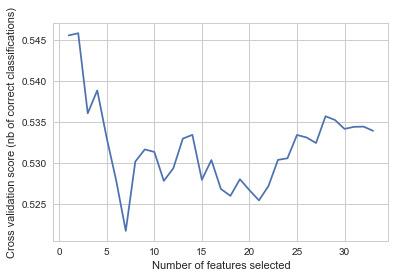

SVM
No. included features: 2
No. excluded features: 31
-------------------
             precision    recall  f1-score   support

          0       0.40      0.12      0.18        51
          1       0.57      0.87      0.69        68

avg / total       0.50      0.55      0.47       119



In [33]:
model = svm.SVC(probability=True, kernel='linear')
rfecv = fs.RFECV(estimator=model, cv=10, scoring='roc_auc')

nyse_feature_train_rfe = rfecv.fit_transform(nyse_feature_train,nyse_target_train)

nyse_feature_name_new = [nyse_feature_name[i] for i in rfecv.get_support(indices=True)]
nyse_feature_name_excluded = list(set(nyse_feature_name) - set(nyse_feature_name_new))

model.fit(nyse_feature_train_rfe, nyse_target_train)
nyse_feature_test_rfe = rfecv.transform(nyse_feature_test)

predicted = model.predict(nyse_feature_test_rfe)
probs = model.predict_proba(nyse_feature_test_rfe)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

# generate evaluation metrics
print('SVM')
print('No. included features:', len(nyse_feature_name_new))
print('No. excluded features:', len(nyse_feature_name_excluded)) 
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

#### $\star$ Experiment 6

Highest Accuracy: 0.563800721017
Best k: 57


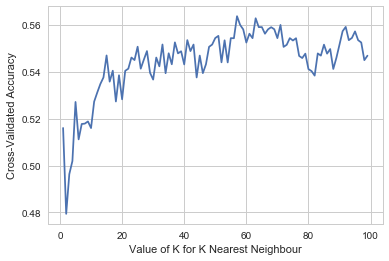

In [34]:
k_range = list(range(1, 100))
k_scores = []

for k in k_range:
    knn = ne.KNeighborsClassifier(n_neighbors=k)
    scores = ms.cross_val_score(knn, nyse_feature_train, nyse_target_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
    
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for K Nearest Neighbour')
plt.ylabel('Cross-Validated Accuracy')

print('Highest Accuracy:', max(k_scores))

k_index = k_scores.index(max(k_scores))
best_k = k_range[k_index]

print('Best k:', best_k)

In [35]:
model = ne.KNeighborsClassifier(n_neighbors=57)
 
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

# generate evaluation metrics
print('Accuracy Score:', metrics.accuracy_score(nyse_target_test, predicted,))
print('ROC Score:', metrics.roc_auc_score(nyse_target_test, probs[:, 1]),'\n')
print('Confusion Matrix: \n', metrics.confusion_matrix(nyse_target_test, predicted))
print('Classification Report: \n', metrics.classification_report(nyse_target_test, predicted))

Accuracy Score: 0.579831932773
ROC Score: 0.605103806228 

Confusion Matrix: 
 [[23 28]
 [22 46]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.51      0.45      0.48        51
          1       0.62      0.68      0.65        68

avg / total       0.57      0.58      0.58       119



In [36]:
# train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_hybrid_standard, nyse_target, test_size=0.1, random_state=0)

model = svm.SVC(probability=True, kernel='linear', cache_size = 1000) #linear’ ‘poly’ ‘rbf’ ‘sigmoid’
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

print('Coefficients')
print('-------------------')
for i in range(len(nyse_feature_name)):
    print(nyse_feature_name[i],':',model.coef_[:,i])

SVM
-------------------
             precision    recall  f1-score   support

          0       0.62      0.39      0.48        51
          1       0.64      0.82      0.72        68

avg / total       0.64      0.64      0.62       119

Coefficients
-------------------
Cash Ratio : [ 0.55645818]
Cash and Cash Equivalents : [-0.45622656]
Current Ratio : [-0.38299485]
Fixed Assets : [ 0.2687416]
Gross Profit : [ 0.01399339]
Intangible Assets : [ 0.01640458]
Long-Term Debt : [ 0.2472834]
Long-Term Investments : [ 0.13308045]
Net Cash Flow : [ 0.04467729]
Net Cash Flow-Operating : [-0.79191085]
Net Cash Flows-Financing : [-0.12740273]
Net Cash Flows-Investing : [-0.20872689]
Net Income : [-0.12628924]
Profit Margin : [-0.08940737]
Quick Ratio : [-0.14378737]
Total Assets : [ 0.62860721]
Total Equity : [ 0.0141012]
Total Liabilities : [-0.55298234]
Total Revenue : [-0.2136378]
Earnings Per Share : [-0.02831594]
Depreciation : [-0.39255485]
Inventory : [ 0.36906754]
Investments : [ 0.00034

#### $\star$ Intuitive Model

In [37]:
nyse_feature_name_final = [
'Cash Ratio'
,'Cash and Cash Equivalents'
,'Current Ratio'
,'Fixed Assets'
,'Long-Term Debt'
,'Net Cash Flow-Operating'
,'Net Cash Flows-Investing'
,'Total Assets'
,'Total Liabilities'
,'Total Revenue'
,'Depreciation'
,'Inventory'
,'Research and Development'
,'Asset Turnover']

final = []
for feature in nyse_feature_name_final:
    i = nyse_feature_name.index(feature)
    arr = nyse_feature_hybrid_standard[:,i]
    final.append(arr)
       
nyse_feature_final = np.column_stack(final)
print(nyse_feature_final.shape)

(1185, 14)


In [38]:
# train/test split 
nyse_feature_train, nyse_feature_test, nyse_target_train, nyse_target_test = ms.train_test_split( \
nyse_feature_final, nyse_target, test_size=0.1, random_state=0)

model = svm.SVC(probability=True, kernel='linear', cache_size = 1000) #linear’ ‘poly’ ‘rbf’ ‘sigmoid’
model.fit(nyse_feature_train, nyse_target_train)

predicted = model.predict(nyse_feature_test)
probs = model.predict_proba(nyse_feature_test)

print('SVM')
print('-------------------')
print(metrics.classification_report(nyse_target_test, predicted))

print('Coefficients')
print('-------------------')
for i in range(len(nyse_feature_name_final)):
    print(nyse_feature_name_final[i],':',model.coef_[:,i])

SVM
-------------------
             precision    recall  f1-score   support

          0       0.54      0.29      0.38        51
          1       0.60      0.81      0.69        68

avg / total       0.57      0.59      0.56       119

Coefficients
-------------------
Cash Ratio : [ 0.34792491]
Cash and Cash Equivalents : [-0.37053584]
Current Ratio : [-0.37119593]
Fixed Assets : [ 0.30155475]
Long-Term Debt : [ 0.20471455]
Net Cash Flow-Operating : [-0.64476543]
Net Cash Flows-Investing : [-0.06463443]
Total Assets : [ 0.68700583]
Total Liabilities : [-0.45089202]
Total Revenue : [-0.44060576]
Depreciation : [-0.18849734]
Inventory : [ 0.34591923]
Research and Development : [ 0.24243051]
Asset Turnover : [ 0.37874116]


### 2. Random Forest, XGBoost

In [39]:
import xgboost as xgb
from sklearn import ensemble
from sklearn.metrics import roc_auc_score
from sklearn import tree, preprocessing, ensemble
from sklearn import decomposition
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [40]:
# load data
prices = pd.read_csv('datasets/prices.csv', low_memory = False)
fundamentals = pd.read_csv('datasets/fundamentals.csv', low_memory = False)
securities = pd.read_csv('datasets/securities.csv', low_memory = False)

In [41]:
# enrich fundamentals
fundamentals['Goodwill to Assets']  \
            = fundamentals['Goodwill'] / fundamentals['Total Assets']
fundamentals['Investing Cashflow to Assets'] \
            = fundamentals['Net Cash Flows-Investing'] / fundamentals['Total Assets']
fundamentals['Operating Cashflow to Operating Income'] \
            = fundamentals['Net Cash Flow-Operating'] / fundamentals['Operating Income']
fundamentals['Equity to Assets'] \
            = fundamentals['Total Equity'] / fundamentals['Total Assets']
fundamentals['Cash per Share'] \
            = fundamentals['Cash and Cash Equivalents'] / fundamentals['Estimated Shares Outstanding']

In [42]:
fundamentals = fundamentals[['Ticker Symbol', 'Period Ending', 'Earnings Per Share', 'Cash Ratio', 
                             'Current Ratio', 'Operating Margin', 'Gross Margin', 'Profit Margin', 
                             'Goodwill to Assets', 'Investing Cashflow to Assets', 
                             'Operating Cashflow to Operating Income','Equity to Assets', 'Cash per Share']]

securities = securities[['Ticker symbol', 'Security', 'GICS Sector', 'GICS Sub Industry']]

main_df = fundamentals.merge(securities, how = 'left', left_on = 'Ticker Symbol', right_on = 'Ticker symbol')

We need to create a data frame of all possible stock tickers and dates (between min and max that occurs in dataset) to do this, firstly I created data frames with unique symbols, secondly a dataframe with unique dates that have been padded, which means all dates that are missing in the list of unique values (due to weekend days or bank holidays) will be added.

In [43]:
symbols = pd.DataFrame(np.unique(prices['symbol']), columns = ['symbol'])
dates = pd.DataFrame(pd.date_range(pd.to_datetime(prices['date'].min()), pd.to_datetime(prices['date'].max())), 
                     columns = ['date'])

# symbols and dates need to be joined using  cartesian product
# a dummy key needs to be added to both symbols and dates data frames
symbols['key'] = 1
dates['key'] = 1

#add cartesian join here:
date_symbol_padded = symbols.merge(dates, on = 'key')

del date_symbol_padded['key']

Things needto be done to prepare data for analysis:
- lookup for missing date values in prices dataset and fill with previous day prices
- create 'prices_enriched' being a self join showing price on date 'A' and on date 'A + 1 year'
- join using period ending date and date

In [44]:
prices['date_formatted'] = pd.to_datetime(pd.Series(prices['date']))
prices_enriched = date_symbol_padded.merge(prices, how = 'left', 
                                    left_on = ['symbol', 'date'], right_on = ['symbol', 'date_formatted'])

# within padded data (named 'prices_enriched'), let's fill all missing dates with last valid record,
# for example, on Sunday, price of an asset is equal to close price on Monday
prices_enriched.fillna(method='ffill', inplace=True)
prices_enriched['date_year_after']=pd.to_datetime(pd.Series(prices_enriched['date_x']))+dt.timedelta(days=365)

prices_complete = prices_enriched.merge(prices_enriched, how = 'left',
                                left_on = ['symbol', 'date_year_after'], right_on = ['symbol', 'date_x'])
prices_complete = prices_complete[['symbol', 'date_x_x', 'close_x', 'date_year_after_x', 'close_y']
                                 ].rename(columns = {'date_x_x': 'date', 
                                                    'close_x': 'close', 
                                                    'date_year_after_x': 
                                                    'date_year_after', 
                                                    'close_y': 'close_year_after'})

In [45]:
main_df['Period Ending date'] = pd.to_datetime(pd.Series(main_df['Period Ending']))
main_df = main_df.merge(prices_complete,  how = 'left',
                        left_on = ['Ticker Symbol', 'Period Ending date'],  right_on = ['symbol', 'date'])

main_df['price_change'] = (main_df['close_year_after'] / main_df['close']) - 1

main_df_tree = main_df[['Earnings Per Share', 'Cash Ratio', 'Current Ratio', 
                        'Operating Margin', 'Gross Margin', 'Profit Margin',
                        'Goodwill to Assets', 'Investing Cashflow to Assets', 
                        'Operating Cashflow to Operating Income', 'Equity to Assets', 
                        'Cash per Share', 'price_change']].dropna()

main_df_tree['up_down'] = "" 
main_df_tree['up_down'][main_df_tree['price_change'] > 0] = 'up'
main_df_tree['up_down'][main_df_tree['price_change'] < 0] = 'down'
main_df_tree['up_down'][main_df_tree['price_change'] == 0] = 'no_change'

In [46]:
# create variables needed to run decision tree
x_train, x_test, y_train, y_test = train_test_split(
    main_df_tree[['Earnings Per Share', 'Cash Ratio', 'Current Ratio', 'Operating Margin', 'Gross Margin', 
                  'Profit Margin', 'Goodwill to Assets', 'Investing Cashflow to Assets', 
                  'Operating Cashflow to Operating Income', 'Equity to Assets', 'Cash per Share']],
    main_df_tree[['up_down']], test_size = 0.3 )

In [47]:
rfc = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=1000, max_depth=3,
                                      max_features = 5, min_samples_split=150)
rfc = rfc.fit(X = x_train, y = y_train)
print(rfc.score(x_test, y_test))

0.63025210084


In [48]:
pd.DataFrame(rfc.feature_importances_, columns = ["Importance"], 
          index = main_df_tree[['Earnings Per Share', 'Cash Ratio', 'Current Ratio', 'Operating Margin', 
                                'Gross Margin', 'Profit Margin', 'Goodwill to Assets', 
                                'Investing Cashflow to Assets', 'Operating Cashflow to Operating Income', 
                                'Equity to Assets', 'Cash per Share']]
             .columns).sort_values(['Importance'], ascending = False)

,Importance
Earnings Per Share,0.2074
Investing Cashflow to Assets,0.1960
Cash per Share,0.1664
Current Ratio,0.0900
Goodwill to Assets,0.0768
Operating Cashflow to Operating Income,0.0625
Equity to Assets,0.0544
Cash Ratio,0.0471
Gross Margin,0.0414
Operating Margin,0.0291


In [49]:
# use grid search to find parameters that are optimal for the Decision Tree Classifier

param_grid = {'max_depth': [6], 
              'min_samples_split': [150],
              'max_features': [5]}

tree = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv = 3)
tree.fit(x_train.values, y_train['up_down'].values )

print(tree.best_params_)
print(tree.best_score_)

{'max_depth': 6, 'max_features': 5, 'min_samples_split': 150}
0.666265060241


Let's have a short break from classification using decision tree & random forest and let's try applying dimensionality reduction.

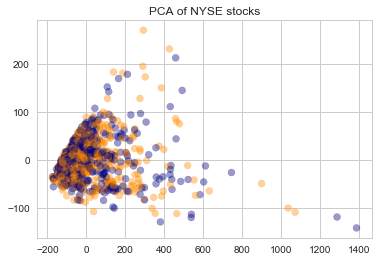

In [50]:
pca_data = main_df_tree[['Earnings Per Share', 'Cash Ratio', 'Current Ratio', 
                         'Operating Margin', 'Gross Margin', 'Profit Margin', 'up_down']]

pca_data_x = pca_data[['Earnings Per Share', 'Cash Ratio', 'Current Ratio', 
                       'Operating Margin', 'Gross Margin', 'Profit Margin']]

pca_data_y = pca_data[['up_down']]

pca = decomposition.PCA(n_components=2)
pca.fit(pca_data_x)

pca_data_x_r = pca.transform(pca_data_x)

colors = ['navy', 'darkorange']
for color, i, target_name in zip(colors, ['up', 'down'], pca_data_y):
    plt.scatter(pd.DataFrame(pca_data_x_r)[0], pd.DataFrame(pca_data_x_r)[1], color = colors, alpha = 0.4,
               label = pca_data_y)
plt.title('PCA of NYSE stocks')

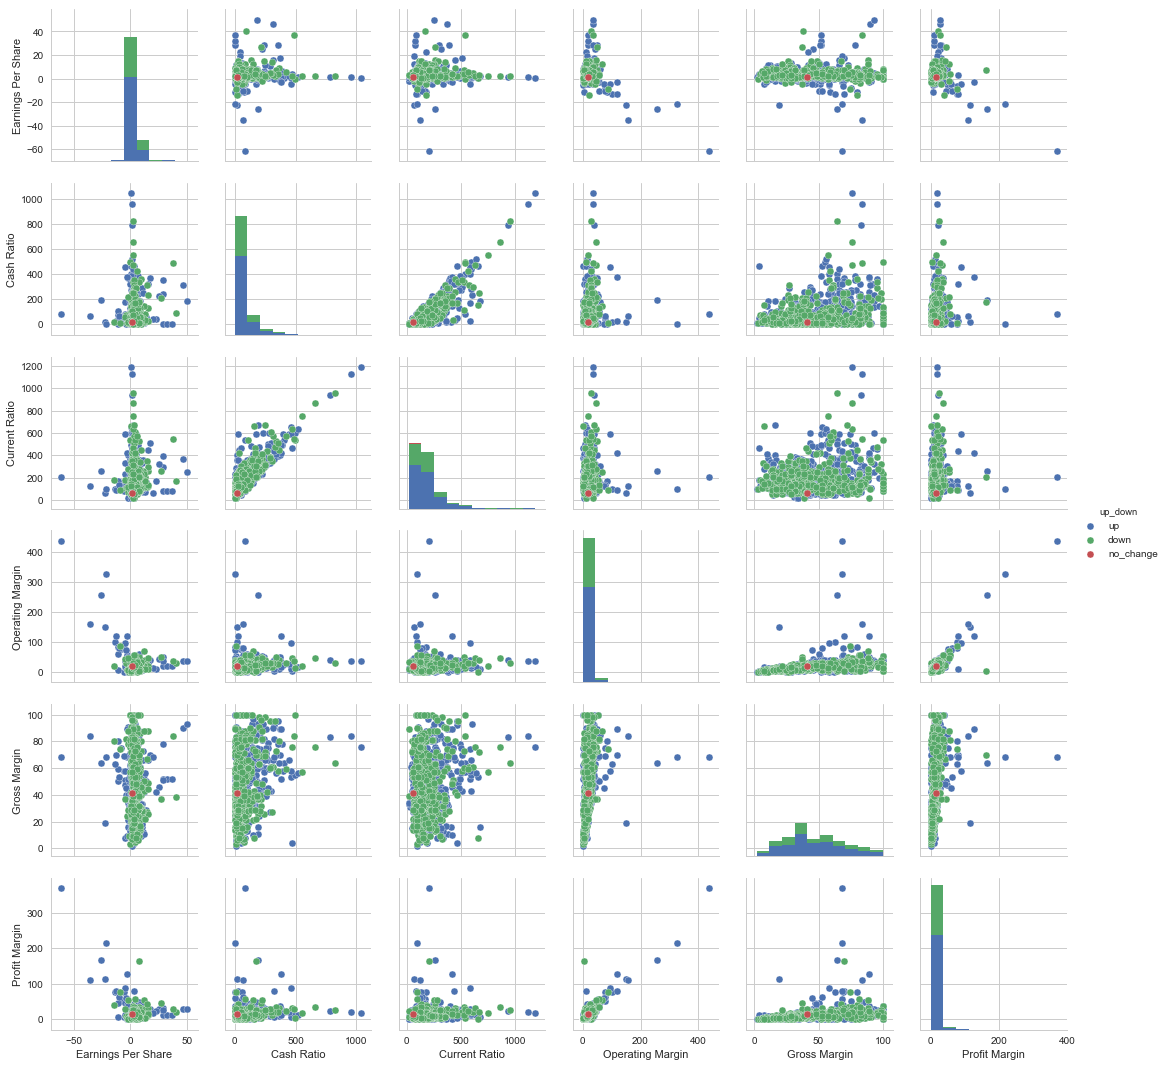

In [51]:
sns.pairplot(pca_data.dropna(), hue='up_down')

The classification method ('up', 'down', 'no_change') doesn't seem to fit well into needs of stock market analyst. Let's try xgboost regression, so that we can estimate not only the direction of share price movement, but also how much a price is going to rise.

In [52]:
xgb_df = main_df[['Earnings Per Share', 'Cash Ratio', 'Current Ratio', 'Operating Margin', 
                  'Gross Margin', 'Profit Margin','Goodwill to Assets', 'Investing Cashflow to Assets', 
                  'Operating Cashflow to Operating Income', 'Equity to Assets', 'Cash per Share', 
                  'price_change']].dropna()

In [53]:
x_train, x_test, y_train, y_test = train_test_split(
                  xgb_df[['Earnings Per Share', 'Cash Ratio', 'Current Ratio', 
                         'Operating Margin', 'Gross Margin', 'Profit Margin',
                         'Goodwill to Assets', 'Investing Cashflow to Assets', 
                         'Operating Cashflow to Operating Income', 'Equity to Assets', 'Cash per Share']],
                  xgb_df[['price_change']], test_size = 0.3 )

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

In [54]:
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1}

cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=2000,
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)

print("n_estimators:", num_boost_rounds)

[0]	train-rmse:0.497447	test-rmse:0.49752
[50]	train-rmse:0.426153	test-rmse:0.431637
[100]	train-rmse:0.374884	test-rmse:0.38663
[150]	train-rmse:0.337917	test-rmse:0.356333
[200]	train-rmse:0.310247	test-rmse:0.336539
[250]	train-rmse:0.289923	test-rmse:0.323946
[300]	train-rmse:0.274295	test-rmse:0.316213
[350]	train-rmse:0.262083	test-rmse:0.311672
[400]	train-rmse:0.252258	test-rmse:0.309057
[450]	train-rmse:0.244186	test-rmse:0.307603
[500]	train-rmse:0.237312	test-rmse:0.306807
[550]	train-rmse:0.231194	test-rmse:0.306402
n_estimators: 540


In [55]:
# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

In [56]:
# make predictions
y_pred = model.predict(dtest)
y_pred[:5]

array([ 0.12107298,  0.31182948,  0.18777785,  0.18906868,  0.18707401], dtype=float32)

### 3. Keras

In [57]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [58]:
prices = pd.read_csv("datasets/prices-split-adjusted.csv", index_col = 0)

# move close to the last column
prices["adj close"] = prices.close 

# move close to the last column
prices.drop(['close'], 1, inplace=True) 

# extract a particular price for stock in symbols: use GOOG as an example
AAPL = prices[prices.symbol == 'AAPL']
AAPL.drop(['symbol'],1,inplace=True)
AAPL.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,30.4900,30.3400,30.6429,1.2343e+08,30.5729
2010-01-05,30.6571,30.4643,30.7986,1.5048e+08,30.6257
2010-01-06,30.6257,30.1071,30.7471,1.3804e+08,30.1386
2010-01-07,30.2500,29.8643,30.2857,1.1928e+08,30.0829
2010-01-08,30.0429,29.8657,30.2857,1.1190e+08,30.2829


In [59]:
# normalize the data
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df

df = normalize_data(AAPL)

In [60]:
# create training set and testing set
def create_datasets(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :]       # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

seq_len = 22
X_train, y_train, X_test, y_test = create_datasets(df, seq_len)

In [61]:
# model structure

def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    
    return model

model = build_model([5,seq_len,1])

Compilation Time :  0.04680013656616211


In [62]:
# fit the model
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 1408 samples, validate on 157 samples
Epoch 1/100
1408/1408 [==============================] - 10s - loss: 0.2378 - acc: 7.1023e-04 - val_loss: 0.3452 - val_acc: 0.0000e+00
Epoch 2/100
1408/1408 [==============================] - 9s - loss: 0.0859 - acc: 0.0014 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 3/100
1408/1408 [==============================] - 9s - loss: 0.0689 - acc: 0.0014 - val_loss: 0.0432 - val_acc: 0.0000e+00
Epoch 4/100
1408/1408 [==============================] - 9s - loss: 0.0318 - acc: 0.0014 - val_loss: 0.1176 - val_acc: 0.0000e+00
Epoch 5/100
1408/1408 [==============================] - 9s - loss: 0.0406 - acc: 7.1023e-04 - val_loss: 0.0666 - val_acc: 0.0000e+00
Epoch 6/100
1408/1408 [==============================] - 9s - loss: 0.0197 - acc: 0.0014 - val_loss: 0.0074 - val_acc: 0.0000e+00
Epoch 7/100
1408/1408 [==============================] - 9s - loss: 0.0194 - acc: 0.0014 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 8/100
1408/1408 [===========

1408/1408 [==============================] - 9s - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 64/100
1408/1408 [==============================] - 9s - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 65/100
1408/1408 [==============================] - 9s - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 66/100
1408/1408 [==============================] - 9s - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 67/100
1408/1408 [==============================] - 9s - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 68/100
1408/1408 [==============================] - 9s - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 69/100
1408/1408 [==============================] - 9s - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 70/100
1408/1408 [==============================] - 9s - loss: 0.0013 - acc: 0.0014 - val_

In [63]:
# predict normalized y_values
y_pred = model.predict(X_test)
y_pred[:5]

array([[ 0.78389937],
       [ 0.77913779],
       [ 0.77361703],
       [ 0.76393807],
       [ 0.75191855]], dtype=float32)

In [64]:
# denormalize the data
prices = pd.read_csv("datasets/prices-split-adjusted.csv", index_col = 0)
prices["adj close"] = prices.close 
prices.drop(['close'], 1, inplace=True) 
AAPL = prices[prices.symbol == 'AAPL']
AAPL.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

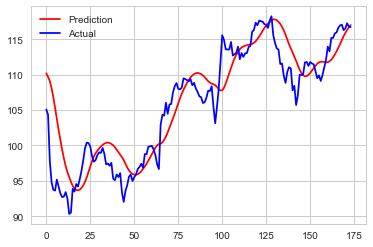

In [65]:
# prediction values vs. actual values
new_y_pred = denormalize(AAPL, y_pred)
new_y_test = denormalize(AAPL, y_test)

plt2.plot(new_y_pred,color='red', label='Prediction')
plt2.plot(new_y_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()

In [66]:
# use F score to evaluate the LSTM model
def model_F_score(newp,newy_test):
    TP=0
    FN=0
    FP=0
    for i in range(len(newp)-1):
        test_prof=newy_test[i+1]-newy_test[i]
        p_prof=newp[i+1] - newp[i]
        if((test_prof>=0) and (p_prof>=0)):
            TP=TP+1
        if ((test_prof>= 0) and (p_prof<0)):
            FN=FN+1
        if ((test_prof<0) and (p_prof>=0)):
            FP=FP+1
    Precision=float(TP)/float(TP+FP)
    Recall=float(TP)/float(TP+FN)
    Fscore= 2.0*Precision*Recall/(Precision+Recall)
    return Fscore  
    
F_score = model_F_score(new_y_pred, new_y_test)
print('F score: %.4f RMSE' % (F_score))

Test_score = math.sqrt(mean_squared_error(new_y_pred, new_y_test))
print('Test score: %.4f RMSE' % (Test_score))

F score: 0.5990 RMSE
Test score: 3.5881 RMSE
